In [12]:
import pandas as pd
import numpy as np
import os
from datetime import datetime as dt, timedelta
from dateutil.relativedelta import *
import re
from matplotlib import pyplot as plt
import seaborn as sns
import sqlite3
import scipy.stats as stats

<h3>SQLite Handling functions</h3>
<p>Use Pandas to import dataframe into SQLlite</p>

In [13]:
DB = "C:\\Users\\jesse\\Documents\\Projects\\hockey_datamvp.db"

#SQL Handle functions
def run_query(q):
    with sqlite3.connect(DB) as conn:
        x = pd.read_sql(q,conn)
    return x
   
#send command
def run_command(c):
    with sqlite3.connect(DB) as conn:
        conn.isolation_level = None
        return conn.execute(c)
    
#show tables
def show_tables():
    r = """
    Select name,type
    FROM sqlite_master
    WHERE type in ("table","view");
        """
    return run_query(r)

In [17]:
q = """WITH player_info AS (
    SELECT unique_id,position 
    FROM player_list) 
        SELECT * FROM player_log pl
        LEFT JOIN player_info pi on pi.unique_id= pl.player_id
        WHERE pi.position = "G" """
goalie_data = run_query(q)

goalie_data.columns

Index(['gamelog_id', 'player_id', 'team_id', 'date_game', 'age', 'min_season',
       'min_3w', 'days_to_next_g', 'timec', 'venuec', 'injured', 'unique_id',
       'position'],
      dtype='object')

In [18]:
np.random.seed(34)
#get random sample
no_injury = goalie_data[goalie_data['injured']==0].iloc[np.random.randint(0,50000,830),:]
injury = goalie_data[goalie_data['injured']==1]

In [19]:
cols = ['age','min_season','min_3w','timec']
for c in cols:
    print(c,stats.ttest_ind(no_injury[c],injury[c]))

age Ttest_indResult(statistic=-4.209336498208755, pvalue=2.702411285040744e-05)
min_season Ttest_indResult(statistic=2.0731878494200253, pvalue=0.03831323941874621)
min_3w Ttest_indResult(statistic=2.021784417929179, pvalue=0.04336345308827741)
timec Ttest_indResult(statistic=0.5513622512356763, pvalue=0.5814617390930408)


In [148]:
#import data
teamtraining = pd.read_csv('gametrainingdata.txt')
teamtraining.drop(columns=['Unnamed: 0','t1_wins','t1_loses','t1_ties','t1_otl',
                           't1_points','t1_total_games','t1_recent_wins', 't1_recent_loses', 't1_recent_ties',
                           't1_recent_otl','t1_recent_points','t2_wins','t2_loses','t2_ties','t2_otl',
                           't2_points','t2_total_games','t2_recent_wins', 't2_recent_loses', 't2_recent_ties',
                           't2_recent_otl','t2_recent_points'],axis=1,inplace=True)

#randomly pull test/training set (reserve 20% for test)
mask = np.random.rand(teamtraining.shape[0]) < 0.8

teamtrain = teamtraining[mask]
teamtrain = teamtrain.dropna(axis = 0)
teamtest = teamtraining[~mask]
teamtest = teamtest.dropna(axis = 0)

<h2>First look at opposing team shots</h2>

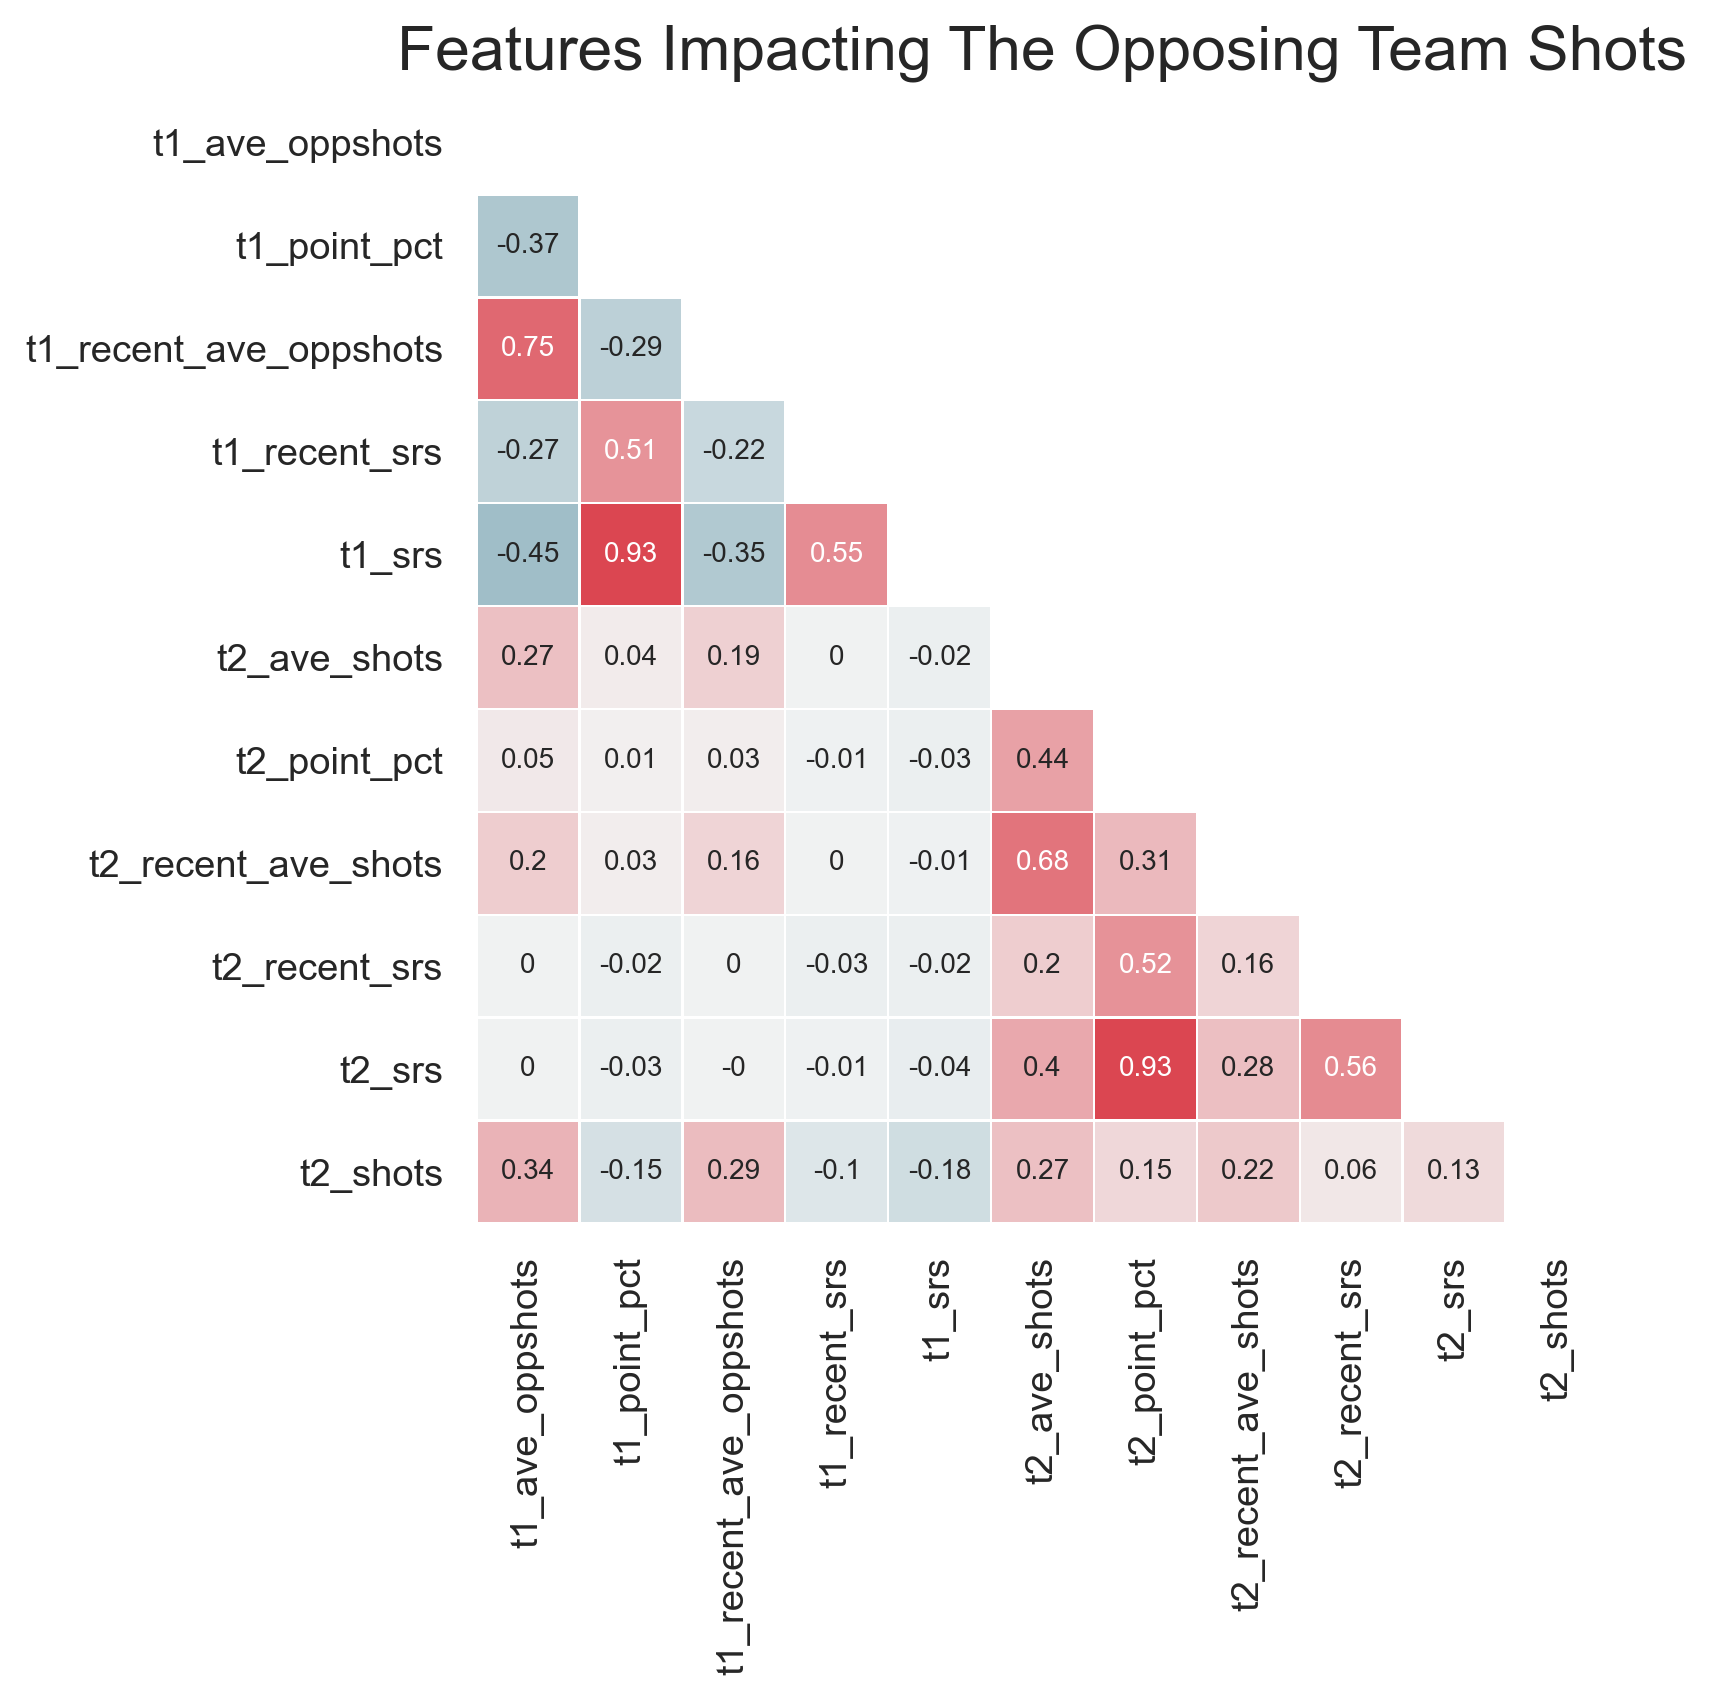

In [89]:
#add test data back for EDA
fig4 = plt.figure(figsize=(12,6),dpi=250)
sns.set(font_scale=1)
corr1 = np.round(teamtrain[['t1_ave_oppshots','t1_point_pct','t1_recent_ave_oppshots','t1_recent_srs',
                           't1_srs','t2_ave_shots','t2_point_pct','t2_recent_ave_shots','t2_recent_srs',
                           't2_srs','t2_shots']].corr(),2)
# Generate a mask for the upper triangle
npmask1 = np.triu(np.ones_like(teamtrain[['t1_ave_oppshots','t1_point_pct','t1_recent_ave_oppshots','t1_recent_srs',
                           't1_srs','t2_ave_shots','t2_point_pct','t2_recent_ave_shots','t2_recent_srs',
                           't2_srs','t2_shots']].corr(), dtype=np.bool))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr1,mask=npmask1,annot=True,annot_kws={"size": 8},square=True,cmap=cmap,vmax=1, center=0,linewidths=.5,  cbar=False)
plt.title('Features Impacting The Opposing Team Shots',fontsize=18)
plt.gca().set_facecolor('white')

In [217]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_validate as CV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

In [246]:
num_pipeline = Pipeline([('std_scaler',StandardScaler())])
traindata = teamtrain[['t1_ave_oppshots','t1_point_pct','t1_recent_ave_oppshots','t1_recent_srs',
                           't1_srs','t2_ave_shots','t2_point_pct','t2_recent_ave_shots','t2_recent_srs',
                           't2_srs']]
trainX = num_pipeline.fit_transform(traindata)
trainY = np.array(teamtrain['t2_shots']).reshape(-1,1)

lin_reg = LinearRegression()
lin_reg.fit(trainX,trainY)


LinearRegression()

In [247]:
#apply to test set  linear regression appears to do best job against other regressors (ridge, gradient boost, random forest)

In [248]:
msa_ave_test = mse(np.array(teamtest['t2_ave_shots']).reshape(-1,1),np.array(teamtest['t2_shots']).reshape(-1,1))
print('The baseline mse is calculated as: %0.2f' % np.sqrt(msa_ave_test))

The baseline mse is calculated as: 6.60


In [249]:
traintest = teamtest[['t1_ave_oppshots','t1_point_pct','t1_recent_ave_oppshots','t1_recent_srs',
                           't1_srs','t2_ave_shots','t2_point_pct','t2_recent_ave_shots','t2_recent_srs',
                           't2_srs']]
testX = num_pipeline.fit_transform(traintest)
testY = np.array(teamtest['t2_shots']).reshape(-1,1)
testYp = lin_reg.predict(testX)

print('The predicted mse is calculated as: %0.2f' % np.sqrt(mse(testY,testYp)))

The predicted mse is calculated as: 6.26


In [250]:
from joblib import dump, load
dump(lin_reg, 'shot_predictor.joblib') 

['shot_predictor.joblib']